<a href="https://colab.research.google.com/github/marcelopinheiro42-tech/MEC503-Topicos_especiais_mecanica_solidos/blob/main/Marcelo_Pinheiro_AtvPINN_AE1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

MARCELO JOEL DOS SANTOS PINHEIRO

RA 24202331032

MEC-502 Topico Especial da Mecanica dos Solidos

GitHub

**EXERCICIO 1**

1) Implemente em PyTorch uma PINN para encontar o deslocamento no problema da barra unidirecional apresentado Fig 1.

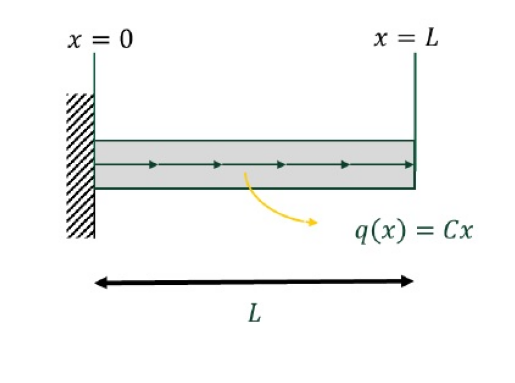

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mping
img_path = '/content/Fig1  Tracao na barra.jpg'
img = mping.imread(img_path)
plt.imshow(img)
plt.axis('off')
plt.show()

**Solução Analitica do problema**

Substituindo $q(x)=Cx$, temos:

$$\frac{d}{dx}\left(EA\frac{du}{dx}\right)=- Cx$$


Integrando uma vez em relação a (x):

$$EA\frac{du}{dx} = - \int Cx dx$$

Integrando:

$$EA\frac{du}{dx} = - \frac{Cx^2}{2} + C_1$$

Integrando uma sengunda vez em relação a (x):

$$u(x) = \frac{1}{EA}\int \left(- \frac{Cx^2}{2} + C_1\right) dx$$

Integrando:

$$u(x) = \frac{1}{EA} \left(- \frac{Cx^2}{6} + C_1x + C_2\right) $$

Plicando as condições dr contorno para encontrar as constantes de integração $C_1$ e $C_2$:

  1. Condição de contorno em $x=0: u(0)=0$

  $$u(x) = \frac{1}{EA} \left( -\frac{C(0)^3}{6} + C_1L + C_2\right) = 0$$

 Portanto:  $$C_2 = 0$$

  2. Condição de contorno em $x=0: u(L) = \frac{CL^3}{3EA}$


  $$u(0)=\frac{1}{EA} \left(-\frac{CL^3}{6} + C_1L + C_2\right) = \frac{CL^3}{3EA}$$

  Como $ C_2 = 0 $

  $x=0: u(L) = \frac{CL^3}{3EA}$
  $$u(0)=\frac{1}{EA} \left(-\frac{CL^3}{6} + C_1L + 0 \right) = \frac{CL^3}{3EA}$$

  $$\frac{CL^3}{3} = C_1L - \frac{CL^3}{6}$$

  portanto:

  $$C_1 = \frac{1}{L} \left( \frac{CL^3}{6} + \frac{CL^3}{3} \right)$$


  $$C_1 = \frac{CL^2}{2}$$

  Substituindo $C_1$ e $C_2$ na solução geral, chegamos á solução analítica correta:

  $$u(x) = \frac{1}{EA}\left(\frac{CL^2X}{2} - \frac{CX^3}{6}\right)$$

  Portanto, solução analítica :

   $$u(x) = \frac{C}{EA}\left(\frac{L^2X}{2} - \frac{X^3}{6}\right)$$

  

**Instalar DeepXDE**

In [ ]:
! pip install -q deepxde

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.2/194.2 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 5.9 MB/s eta 0:00:00


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import deepxde as dde
import torch
dde.backend.backend_name = "pytorch"

No backend selected.
Finding available backend...


Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term


Found tensorflow.compat.v1
Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


**Parâmetros geométricos, materiais e as cargas são:**


*   Modulo de elasticidade $E = 21000.10^-4 kN/
m^2$
*   Momento de Inercia $I = 6510.10^-7 m^4$
*   Comprimento da barra $L = 3m$
*   Constante $P = 16 kN$





In [ ]:
E = 2100000000
I = 0.000651
L = 5
P = 16

**Solução analítica**

In [ ]:
def func(x):
  return -(2*P*L**3)/(6*E*I)

**Definindo o Intervalo**

In [ ]:
geom = dde.geometry.geometry_1d.Interval(0, L)

**Derivadas 1 e 2 ordem**

In [ ]:
# Derivadas de ordem 2
def ddy(x, y):
  return dde.grad.hessian(y, x)

# Derivada de Ordem 1 da Derivada de Ordem 2 ( 3 Derivada)
def dddy(x, y):
  return dde.grad.jacobian(ddy(x, y), x)

# Definicao da EDO do problema
def pde(x, y):
  dy_xx = ddy(x, y)
  return dy_xx - C*x

**Condição de Contorno:**

In [ ]:
def boundary_l(x, on_boundary):
  return on_boundary and np.isclose(x[0], 0)

def boundary_r(x, on_boundary):
  return on_boundary and np.isclose(x[0], L)

bc_left = dde.icbc.DirichletBC(geom, lambda x: 0, boundary_l, boundary_l)
bc_right = dde.icbc.NeumannBC(geom, lambda x: torch.tensor(C, dtype=torch.float32), boundary_r, boundary_r, component=None)

**Dados para o DeepXDE**

In [ ]:
data = dde.data.PDE(geom, pde,[bc_left, bc_right], num_domain=20, num_boundary=2,)

**Criação da rede**

In [ ]:
layer_size = [1] + [50]*3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

model = dde.Model(data, net)
model.compile("adam", lr=1e-3)
model.train()
N_iter = 5000
step = 50
LossHistory, train_state = model.train(iterations=N_iter, display_every=step)